# Gamma-Poisson conjugated model

In [1]:
from utilities.std_imports import *
import numpy.random as rnd
import scipy.stats as ss
import scipy.special as sp
import seaborn as sns; sns.set()
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## From scratch

### Poisson distribution

$\large X \sim Poiss(\lambda) \;:\; P(k) = P(X=k) = \frac{e^{-\lambda} \lambda^k}{k!}$ 

In [2]:
n = 100
lmbda = 2
X = rnd.poisson(lam=lmbda, size=n)
X

array([5, 1, 1, 3, 2, 1, 0, 1, 5, 1, 2, 3, 1, 2, 1, 1, 2, 1, 3, 1, 1, 1,
       3, 0, 2, 2, 3, 6, 4, 0, 3, 2, 2, 4, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2,
       1, 2, 2, 2, 2, 3, 1, 0, 1, 0, 4, 3, 1, 5, 1, 1, 2, 2, 4, 0, 3, 1,
       5, 3, 2, 2, 3, 1, 2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 1, 0, 3, 1, 3,
       0, 2, 3, 3, 0, 1, 2, 3, 3, 4, 3, 3])

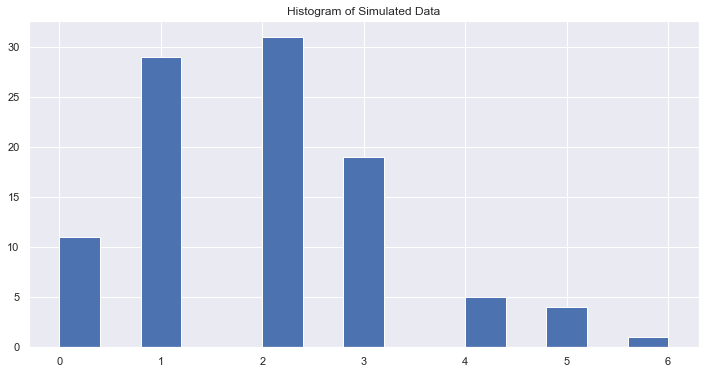

In [3]:
plt.figure(figsize=(12, 6))
plt.hist(X, bins=15)
plt.title('Histogram of Simulated Data');

### Gamma distribution

$\large \lambda \sim \Gamma(a,b) \;:\; \frac{b^a}{\Gamma(a)} \lambda^{a-1} e^{-b \lambda}$

### Prior

Prior gamma distribution : a (shape), b (rate = 1/scale)

In [4]:
a = 3.5
b = 2
prior = lambda x: ss.gamma.pdf(x, a=a, scale=1/b)

Text(0.5, 1.0, 'Gamma Density Function')

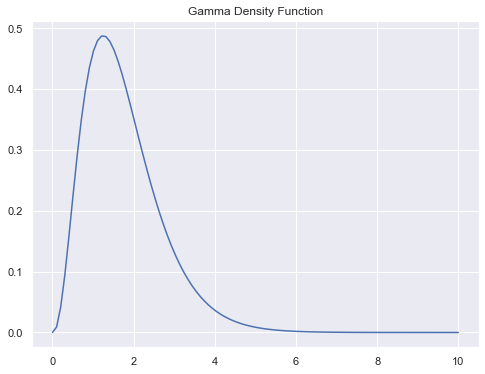

In [5]:
x = np.linspace(start=0, stop=10, num=100)
y = prior(x)
plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.title('Gamma Density Function')

### Likelihood
Product of Poisson probabilies (independence assumption)

$\large P(X|\lambda) = \prod_{i=1}^n \frac{e^{-\lambda} \lambda^{x_i}}{x_i!} = \frac{e^{-n \lambda} \lambda \sum_{i=1}^n x_i}{\prod_{i=1}^n x_i!}$

In [6]:
def likelihood(lmbda,x):
    factorials = np.apply_along_axis(lambda x: sp.gamma(x+1), axis=0, arr=y)
    
    num = np.exp(-lmbda*y.size)*(lmbda**y.sum())
    den = np.multiply.reduce(factorials)
    
    return num/den

### Posterior
Up to a constant (proportional)

$\large P(X|\lambda) \propto Likelihood \times Prior \propto P(X|\lambda) P(\lambda) \propto e^{-n \lambda} \lambda \sum_{i=1}^n x_i \lambda^{a-1} e^{-b \lambda}
\propto \lambda^{(\sum_{i=1}^n x_i + a)-1} e^{-(n+b)\lambda}$

In [7]:
def posterior(lmbda, y):
    return likelihood(lmbda, y) * prior(lmbda)

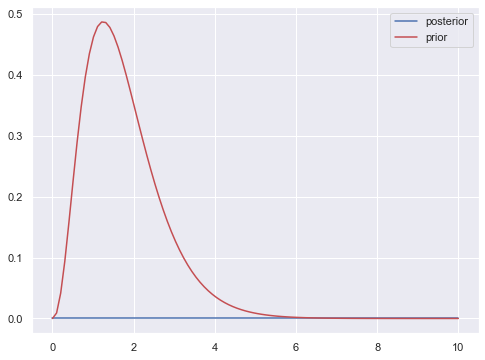

In [8]:
#scale_factor = 2.0e74
y = posterior(x,y) #* scale_factor

plt.figure(figsize=(8, 6))
plt.plot(x, y, label='posterior')
plt.plot(x, ss.gamma.pdf(x, a=a, scale=1/b), 'r-', label='prior')
plt.legend();

## With PyMC3

In [9]:
model = pm.Model()

with model:
    
    lmbda = pm.Gamma('lambda', alpha=a, beta=b)
    
    x_obs = pm.Poisson('y_obs', mu=lmbda, observed=x)
    
    trace = pm.sample(draws=2000, chains=3)

<ipython-input-9-b55ad9f746e9>:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=2000, chains=3)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [lambda]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 35 seconds.


<ipython-input-10-d8a578c3a685>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);
D:\ProgramFiles\Python39\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


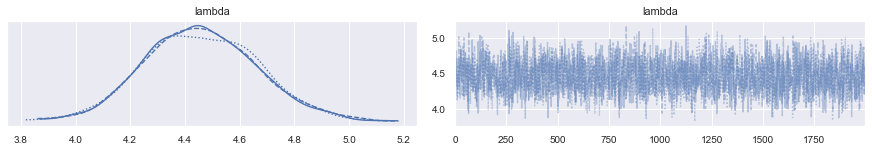

In [10]:
pm.traceplot(trace);

D:\ProgramFiles\Python39\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


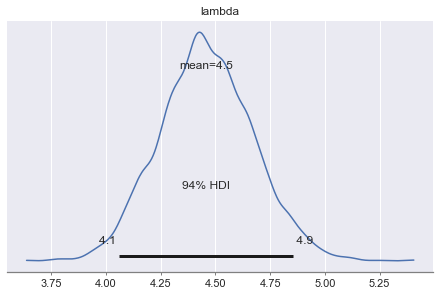

In [76]:
pm.plot_posterior(trace);

### Credits & Links

https://juanitorduz.github.io/intro_pymc3/